# Detecting rooftop available surface for installing PV modules in aerial images using Machine Learning

In [230]:
import numpy as np
import matplotlib.pyplot  as plt
import torch
from torch.autograd import Variable
from torchvision.transforms.functional import normalize
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, ConcatDataset

from process_data.data_noara_loader import *
from model.unet import *
from loss.loss import *
from process_data.data_loader import *
from hyperparameters.select_param import *
from process_data.import_test import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#seed_torch()

# Loading the Data Set
First we load the data set that we will use for training. Each sample is an image with its mask (label). An image is represented as a 3x250x250 array with each of the 3 color chanel being 250x250 pixels. The asssociated mask is a 250x250 array, 

In [3]:
folder_path_image = 'data/image_residencial'
folder_path_mask  = 'data/mask_residencial'
folder_path_noara  = 'data/noARA'

#load dataset
dataset = ConcatDataset([DataLoaderSegmentation(folder_path_image,folder_path_mask),DataLoaderSegmentation(folder_path_noara)])

#split into train, val, test
dataset_size = len(dataset)
train_size = int(0.8*len(dataset))
val_size = int(0.1*len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_set,batch_size=2, shuffle=True ,num_workers=0)
val_loader = DataLoader(val_set,batch_size=2, shuffle=True ,num_workers=0)
test_loader = DataLoader(test_set,batch_size=2, shuffle=True ,num_workers=0)

model = UNet(3,1,False).to(device)


In [89]:
from torch.utils.data import TensorDataset, DataLoader
nimages = 0
mean = 0.
std = 0.
for batch, _ in train_loader:
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    std += batch.std(2).sum(0)

# Final step
mean /= nimages
std /= nimages

print(mean)
print(std)


tensor([-0.0025, -0.0093, -0.0037])
tensor([1.0032, 1.0053, 1.0127])


# Training Loop

In [ ]:
num_epochs = 200
model = UNet(3,1,False).to(device)
loss_function = torch.nn.BCEWithLogitsLoss(weight=torch.FloatTensor([6]).cuda())
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trained_model = training_model(train_loader,loss_function,optimizer,model,num_epochs)

In [ ]:
model = trained_model

## Export or Load trained model

In [17]:
torch.save(model.state_dict(), 'model/'+input('Name of the model file:')+".pt")

In [4]:
path = 'model/'+input('Name of the model file:')+".pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Training with adaptative learning rate

In [16]:
num_epochs = 300
loss_function = torch.nn.BCEWithLogitsLoss(weight=torch.FloatTensor([6]).cuda())
model = UNet(3,1,False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.63, last_epoch=-1, verbose=False)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=0.01, last_epoch=-1, verbose=True)

history_train_loss, history_val_loss, history_train_iou, history_val_iou = training_model(train_loader,loss_function,optimizer,model,num_epochs,scheduler)


Epoch n. 0 Train Loss 1.5 Time Remaining 392.0
Epoch n. 25 Train Loss 1.13 Time Remaining 494.3
Epoch n. 50 Train Loss 0.83 Time Remaining 368.1
Epoch n. 75 Train Loss 0.71 Time Remaining 346.7
Epoch n. 100 Train Loss 0.55 Time Remaining 312.8
Epoch n. 125 Train Loss 0.47 Time Remaining 261.7
Epoch n. 150 Train Loss 0.42 Time Remaining 263.7
Epoch n. 175 Train Loss 0.43 Time Remaining 239.9
Epoch n. 200 Train Loss 0.36 Time Remaining 213.5
Epoch n. 225 Train Loss 0.33 Time Remaining 181.6
Epoch n. 250 Train Loss 0.32 Time Remaining 154.9
Epoch n. 275 Train Loss 0.29 Time Remaining 129.3
Epoch n. 300 Train Loss 0.26 Time Remaining 119.8
Epoch n. 325 Train Loss 0.25 Time Remaining 89.5
Epoch n. 350 Train Loss 0.27 Time Remaining 56.1
Epoch n. 375 Train Loss 0.24 Time Remaining 32.0


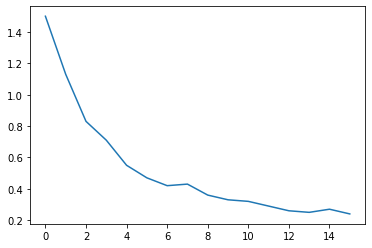

In [174]:
plt.plot([1.5,1.13,0.83,0.71,0.55,0.47,0.42,0.43,0.36,0.33,0.32,0.29,0.26,0.25,0.27,0.24])

# Cross Validation

In [ ]:
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([6]).cuda())
n_splits = 2
num_epochs = 10
lr = 0.01

iou_, acc_ = cross_validation(train_dataset=train_set,n_splits, loss_function, num_epochs, lr)

# Find Best Learning Rate

In [ ]:
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([6]).cuda())
n_splits = 2
num_epochs = 10
lr = np.logspace(-1,-2,num=5)

best_lr, best_iou = select_hyper_param(train_dataset,n_splits,loss_function,num_epochs,lr_candidates)

# Adaptative Learning
We may do a grid search on the learning rates with cross validation to find the best learning_rate. For now the used metric is iou.

In [ ]:
lr_candidates = np.logspace(-1,-2,num=5)
num_epochs = 5
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([6]).cuda())

best_model = UNet(3,1,False).to(device)

best_iou, history_iou = adptative_learning(train_set,val_loader,loss_function,best_model,num_epochs,lr_candidates)


In [ ]:
torch.save(best_model.state_dict(), 'model/best_model06122020.pt')

# Visualization of the model

## Display a image with its mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


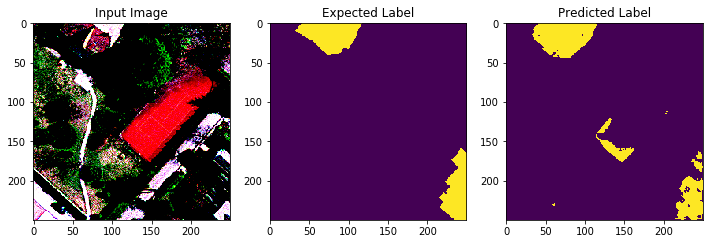

0.6485 0.968976


In [234]:
fig = plt.figure()
fig.set_size_inches(12, 7, forward=True)

ax1 = fig.add_subplot(1,3,1)
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(1,3,2)
ax2.title.set_text('Expected Label')
ax3 = fig.add_subplot(1,3,3)
ax3.title.set_text('Predicted Label')

index_random_sample = int(np.random.random()*len(train_loader.dataset))
(x,y) = train_loader.dataset[index_random_sample]
ax1.imshow(np.transpose(normalize(x,[0.0025*1.0032**(-1), 0.0093*1.0053**(-2), 0.0037*1.0127**(-1)],[1.0032**(-2), 1.0053**(-2), 1.0127**(-2)]).numpy(),(1,2,0)))

ax2.imshow(y)

ypred = torch.squeeze(model.predict(torch.unsqueeze(x,0).cuda())).cpu().detach().numpy()

ax3.imshow(np.around(ypred))
np.around(iou(np.around(ypred),y.numpy()),4),accuracy(np.around(ypred),y.numpy())
acc = np.around(iou(np.around(ypred),y.numpy()),4)
plt.show()
print(acc,accuracy(np.around(ypred),y.numpy()))

## Display an unseen image

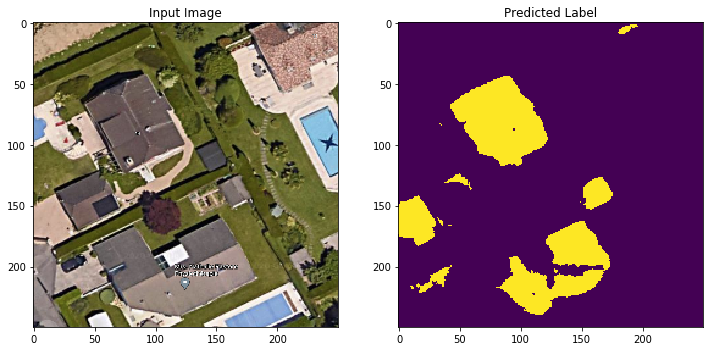

In [163]:
import_and_show(model,'test.png') # Note that 'test.png' should be located in the root of the folder

In [172]:
val = []
for i in range(10):
    print(i)
    val.append(test_model(test_loader,model))
np.mean(val)

0
1
2
3
4
5
6
7
8
9


0.9256283370818595